In [22]:
import sys
sys.path.append("..")
import functions
from functions import *
data = load_dataset()
!pip install optuna
import optuna

In [23]:
data.head()

,Mission ID,Mission Name,Launch Date,Target Type,Target Name,Mission Type,Distance from Earth (light-years),Mission Duration (years),Mission Cost (billion USD),Scientific Yield (points),Crew Size,Mission Success (%),Fuel Consumption (tons),Payload Weight (tons),Launch Vehicle
0,MSN-0001,Mission-1,2025-01-01,Star,Titan,Colonization,7.05,5.2,526.68,64.3,21,100.0,731.88,99.78,SLS
1,MSN-0002,Mission-2,2025-01-08,Exoplanet,Betelgeuse,Colonization,41.76,23.0,234.08,84.4,72,89.6,4197.41,45.72,Starship
2,MSN-0003,Mission-3,2025-01-15,Asteroid,Mars,Exploration,49.22,28.8,218.68,98.6,16,98.6,4908.00,36.12,Starship
3,MSN-0004,Mission-4,2025-01-22,Exoplanet,Titan,Colonization,26.33,17.8,232.89,36.0,59,90.0,2569.05,40.67,Starship
4,MSN-0005,Mission-5,2025-01-29,Exoplanet,Proxima b,Mining,8.67,9.2,72.14,96.5,31,73.2,892.76,12.40,Starship


#   CW Question 3: How does data augmentation affect the performance of a Neural Network

To answer this question I will apply my **Multi Layer Perceptron Regressor** neural network along with optuna hyperparameter fitting code to my original dataset, an augmented dataset I created in Q1 as well as a more fine tuned augmentation of my dataset in order to compare base outcome RMSE and R square score to random augmentation as well as more precise augmentation that deliberately highlights trends and relations in my data.

##  Step by step
### Step 1) Basic data
To train and test my NN on my dataset I will removed unneeded columns and changed some features into numerical figures through One Hot Encoding.  Then I will be able to redesign my neural network with a variable parameters and use the optuna plugin to comb through all of the best combinations. 
### Step 2) Meaningfully augmented
Then I can further augment my data by making a copy of it and adding engineered features that will introduce new types of relations such as logarithmic relations, squares, cubes and scaled relations. Then I will retrain the model on this data and find the RMSE and R square score.
### Step 3) Introducing noise and chaos into the data
After that I will further augment my data with the direct prupose to introduce noise and seemingly unrelated relations between **Mission Success** and other features, in order to train the model to ignore unrelated features and correlations.
### Step 4) Results
Finally I can compare the three results and draw conclusions from them

#   Attempt 1- basic dataset

## Feature Engineering through One Hot Encoding
The removal of **Mission ID** and  **Mission Name** as well as changing **Launch Date** to be days since a standard date, and changing **Target Type** and **Target Name** to binary flags as not to skew the data and introduce false heirarchy in the feature columns eg if star-0, Exoplanet-1, Asteroid-2, Moon-3, Planet-4 this introduces an artificial structuring that the NN will assume, where as I want each feature to have equal weight. 

In [24]:
data_1 = data.copy()
#changing launch date to numerical value (number of days since 1st Jan 2000) https://www.geeksforgeeks.org/python/python-pandas-to_datetime/
data_1['Launch Date'] = pd.to_datetime(data_1['Launch Date'])#convert to datetime object
reference_date = pd.to_datetime('2000-01-01')#reference date
data_1['Launch Date'] = (data_1['Launch Date'] - reference_date).dt.days#convert to number of days since reference date

catagory_cols = ['Target Type', 'Target Name', 'Mission Type', 'Launch Vehicle']#listing the catagories for the one hot encoder
X = data_1.drop(['Mission Success (%)', 'Mission ID', 'Mission Name'], axis=1)#splitting the data into useful features and target variable
y = data_1['Mission Success (%)']
catagory_cols = [c for c in catagory_cols if c in X.columns]#filtering the catagory columns 
number_cols = [c for c in X.columns if c not in catagory_cols]#filtering the numerical columns

#   as I am not running the data through a Gradient Boost Regressor like in Q1, I will just use the pandas get_dummies methods of encoding my data which does the same thing. 
#   geeksforgeeks.org/pandas/python-pandas-get_dummies-method/

encoded_1 = pd.get_dummies(X, columns = ['Target Type','Target Name','Mission Type', 'Launch Vehicle'],dtype = int)
encoded_1.head()


,Launch Date,Distance from Earth (light-years),Mission Duration (years),Mission Cost (billion USD),Scientific Yield (points),Crew Size,Fuel Consumption (tons),Payload Weight (tons),Target Type_Asteroid,Target Type_Exoplanet,...,Target Name_Proxima b,Target Name_Titan,Mission Type_Colonization,Mission Type_Exploration,Mission Type_Mining,Mission Type_Research,Launch Vehicle_Ariane 6,Launch Vehicle_Falcon Heavy,Launch Vehicle_SLS,Launch Vehicle_Starship
0,9132,7.05,5.2,526.68,64.3,21,731.88,99.78,0,0,...,0,1,1,0,0,0,0,0,1,0
1,9139,41.76,23.0,234.08,84.4,72,4197.41,45.72,0,1,...,0,0,1,0,0,0,0,0,0,1
2,9146,49.22,28.8,218.68,98.6,16,4908.00,36.12,1,0,...,0,0,0,1,0,0,0,0,0,1
3,9153,26.33,17.8,232.89,36.0,59,2569.05,40.67,0,1,...,0,1,1,0,0,0,0,0,0,1
4,9160,8.67,9.2,72.14,96.5,31,892.76,12.40,0,1,...,1,0,0,0,1,0,0,0,0,1


##  Creating my NN

Again I chose to use a **Multi Layer Perceptron Regressor** as my data is still the same type as it was before, all continuous numerical data points. First I need to create a train validation and test split of my data so that I can train it on the first, then validate my hyperparameters on validation using optuna and finally test my model on new unseen data on the third. 

In [25]:
X = encoded_1.values.astype(np.float32)#   converting to a long type float from integers
scaler = StandardScaler()
X_scaled= scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)
print(X_tensor.shape)
print(y_tensor.shape)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42)#    90% split after train and validation split 
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size = 0.5, random_state=42)

train_dataset = TensorDataset(X_train,y_train)
validation_dataset = TensorDataset(X_val,y_val)
test_dataset = TensorDataset(X_val,y_val)


torch.Size([500, 28])
torch.Size([500, 1])


In [26]:
class myNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, hidden_units, dropout_rate):
        super().__init__()
        layers = []
        in_dim = input_dim

        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_dim, hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_units

        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def objective(trial):
    hidden_layers = trial.suggest_int('hidden_layers',2,7)# ranges of hyperparameters that optuna can go between
    hidden_units = trial.suggest_int('hidden_units',16,128)
    dropout_rate = trial.suggest_float('dropout_rate',0.1,0.5)
    learning_rate = trial.suggest_float('learning_rate',0.0001,0.01)
    batch_size = trial.suggest_categorical('batch_size',[32,64,128])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    net = myNN(input_dim=X.shape[1], hidden_layers=hidden_layers, hidden_units=hidden_units, dropout_rate=dropout_rate)
    criterion = nn.MSELoss()
    optimiser = optim.Adam(net.parameters(),lr=learning_rate)

    epochs = 50
    for epoch in range(epochs):
        net.train()#    training mode
        running_loss = 0
        for X_batch,y_batch in train_loader:
            optimiser.zero_grad()       # zero the gradient buffers
            outputs = net(X_batch)       # forward pass
            loss = criterion(outputs, y_batch)  # compute loss
            loss.backward()             # backward pass
            optimiser.step()            # update weights
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss/len(train_loader.dataset)
    


    val_loss = 0
    net.eval()# validation mode
    all_preds =[]
    all_trues =[]
    with torch.no_grad():
        for X_batch, y_batch in validation_loader:
            preds = net(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds)
            all_trues.append(y_batch)
    all_preds = torch.cat(all_preds).flatten()
    all_trues = torch.cat(all_trues).flatten()
    val_loss = criterion(all_preds, all_trues).item()
    return val_loss

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)#    to improve accuracy change n trials

print("Best trial:")
trial = study.best_trial
print(trial.params)

Best trial:
{'hidden_layers': 5, 'hidden_units': 112, 'dropout_rate': 0.40147641902967485, 'learning_rate': 0.008879982974505003, 'batch_size': 32}


### Here I have used optuna to find the best hyperparameters and below I train my model using these and the training dataset

Epoch 20/150 - Test Accuracy (±5.0%): 26.00%
Epoch 40/150 - Test Accuracy (±5.0%): 66.00%
Epoch 60/150 - Test Accuracy (±5.0%): 28.00%
Epoch 80/150 - Test Accuracy (±5.0%): 64.00%
Epoch 100/150 - Test Accuracy (±5.0%): 66.00%
Epoch 120/150 - Test Accuracy (±5.0%): 72.00%
Epoch 140/150 - Test Accuracy (±5.0%): 72.00%
Epoch 150/150 - Test Accuracy (±5.0%): 20.00%


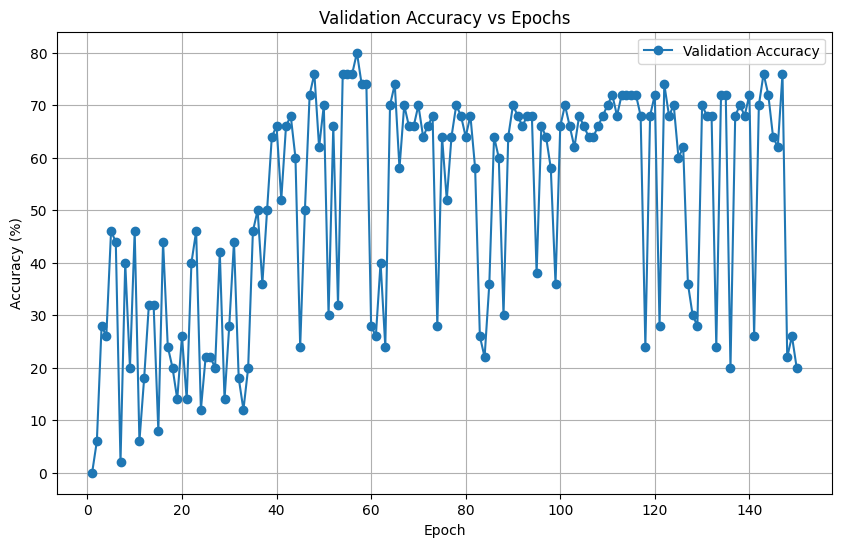

In [27]:
best = study.best_params
net = myNN(input_dim=X_train.shape[1], hidden_layers=best['hidden_layers'],
           hidden_units=best['hidden_units'], dropout_rate=best['dropout_rate'])
criterion = nn.MSELoss()

optimiser = torch.optim.Adam(net.parameters(),lr=best['learning_rate'])
batch_size = best['batch_size']

train_loader_nn = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader_nn = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader_nn = DataLoader(test_dataset, batch_size=batch_size)

val_accuracies=[]
epochs = 150
for epoch in range(epochs):
    net.train()#  
    running_loss = 0
    for X_batch,y_batch in train_loader_nn:
        optimiser.zero_grad()       
        outputs = net(X_batch)      
        loss = criterion(outputs, y_batch)  
        loss.backward()             
        optimiser.step()           
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss/len(train_loader_nn.dataset)

    net.eval()
    val_loss = 0
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for X_batch, y_batch in validation_loader_nn:
            preds = net(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds)
            all_trues.append(y_batch)
    all_preds = torch.cat(all_preds).flatten()
    all_trues = torch.cat(all_trues).flatten()
    rmse = torch.sqrt(torch.mean((all_preds-all_trues)**2))
    tol = 5.0 #tolerance percentage +- 5%
    in_tol = torch.abs(all_preds-all_trues)<=tol
    accuracy = 100*torch.sum(in_tol)/len(all_trues)
    val_accuracies.append(accuracy.item())
    val_loss /= len(validation_loader_nn.dataset)

    if (epoch+1) % 20 ==0:
        print(f"Epoch {epoch+1}/{epochs} - Test Accuracy (±{tol}%): {accuracy:.2f}%")
print(f"Epoch {epoch+1}/{epochs} - Test Accuracy (±{tol}%): {accuracy:.2f}%")
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy vs Epochs')
plt.grid(True)
plt.legend()
plt.show()

##  Final Testing
Above I have trained my neural network on the train dataset and then also on the validation dataset and proved that it is reasonably accurate approximately 74% accurate, but I still need to test it on unseen data below.

In [28]:
net.eval()
all_test_preds = []
all_test_trues = []
with torch.no_grad():
    for X_batch, y_batch in test_loader_nn:
        preds = net(X_batch)
        all_test_preds.append(preds)
        all_test_trues.append(y_batch)

all_test_preds = torch.cat(all_test_preds).flatten()
all_test_trues = torch.cat(all_test_trues).flatten()

y_pred = all_test_preds.numpy()
y_true = all_test_trues.numpy()

rmse = mean_squared_error(y_true, y_pred)

r2 = r2_score(y_true, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2 score: {r2:.4f}")

Test RMSE: 61.1316
Test R^2 score: 0.4245


##  Brief Observations and conclusion

Here my R^2 score is reasonably good, better than I was getting with the overly augmented data in Q2, however the mean squared error means that on average my model's predictions are almost 35 away from their acutal values which when out of 100% is not good. 

#   Attempt 2- Augmenting the Data with meaningful values

Regressors such as a **Multi Layer Perceptron** are sensitive to unscaled data and so feature columns such as Distance, duration, cost, yield,crew, fuel and weight will all need to be scaled using standard scaler once I have engineered new ones. 
I can also introduce logarithmic columns and other similar relationships in order to reduce skewness. 

In [46]:
data_2 = encoded_1.copy()
data_2['Distance from Earth log'] = np.log(data_2['Distance from Earth (light-years)'])
data_2['Mission Duration (years) log'] = np.log(data_2['Mission Duration (years)'])
data_2['Mission Cost (billion USD) log'] = np.log(data_2['Mission Cost (billion USD)'])
data_2['Scientific Yield (points) log'] = np.log(data_2['Scientific Yield (points)'])
data_2['Fuel Consumption (tons) log'] = np.log(data_2['Fuel Consumption (tons)'])
data_2['Payload Weight (tons) log'] = np.log(data_2['Payload Weight (tons)'])
data_2['Launch Date log'] = np.log(data_2['Launch Date'])

scalar = StandardScaler()
data_2['Distance from Earth scaled'] = scalar.fit_transform(data_2[['Distance from Earth log']])
data_2['Mission Duration (years) scaled'] = scalar.fit_transform(data_2[['Mission Duration (years) log']])
data_2['Mission Cost (billion USD) scaled'] = scalar.fit_transform(data_2[['Mission Cost (billion USD) log']])
data_2['Scientific Yield (points) scaled'] = scalar.fit_transform(data_2[['Scientific Yield (points) log']])
data_2['Fuel Consumption (tons) scaled'] = scalar.fit_transform(data_2[['Fuel Consumption (tons) log']])
data_2['Payload Weight (tons) scaled'] = scalar.fit_transform(data_2[['Payload Weight (tons) log']])
data_2['Launch Date scaled'] = scalar.fit_transform(data_2[['Launch Date log']])

data_2.head()
new_2 = data_2.drop(['Distance from Earth log', 'Mission Duration (years) log', 
                         'Mission Cost (billion USD) log','Scientific Yield (points) log',
                         'Fuel Consumption (tons) log','Payload Weight (tons) log',
                         'Distance from Earth (light-years)', 'Mission Duration (years)', 
                         'Mission Cost (billion USD)','Scientific Yield (points)',
                         'Fuel Consumption (tons)','Payload Weight (tons)','Launch Date','Launch Date log'], axis=1)

new_2.head()




,Crew Size,Target Type_Asteroid,Target Type_Exoplanet,Target Type_Moon,Target Type_Planet,Target Type_Star,Target Name_Betelgeuse,Target Name_Ceres,Target Name_Europa,Target Name_Io,...,Launch Vehicle_Falcon Heavy,Launch Vehicle_SLS,Launch Vehicle_Starship,Distance from Earth scaled,Mission Duration (years) scaled,Mission Cost (billion USD) scaled,Scientific Yield (points) scaled,Fuel Consumption (tons) scaled,Payload Weight (tons) scaled,Launch Date scaled
0,21,0,0,0,0,1,0,0,0,0,...,0,1,0,-1.014599,-1.515810,1.202642,0.505236,-0.962920,1.108138,-1.826286
1,72,0,1,0,0,0,1,0,0,0,...,0,0,1,0.833877,0.863034,0.023805,0.957262,0.835752,0.187105,-1.818086
2,16,1,0,0,0,0,0,0,0,0,...,0,0,1,1.004666,1.222830,-0.075123,1.215681,0.996813,-0.091046,-1.809892
3,59,0,1,0,0,0,0,0,0,0,...,0,0,1,0.354611,0.452977,0.016396,-0.458683,0.330186,0.048973,-1.801705
4,31,0,1,0,0,0,0,0,0,0,...,0,0,1,-0.799669,-0.602974,-1.687261,1.179905,-0.758296,-1.352814,-1.793523


### Using the new data
Here i am loading the new augmented data into another NN essentially copied from above with the same test train split and same hyperparameters fine tuning methods using optuna. This is in order to limit differences in the final model's testing phase so that I can clearly see what type of data gets a better testing fit. 

In [82]:
X = new_2.values.astype(np.float32)#   converting to a long type float from integers
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)
print(X_tensor.shape)
print(y_tensor.shape)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42)#    90% split after train and validation split 
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size = 0.5, random_state=42)

train_dataset2 = TensorDataset(X_train,y_train)
validation_dataset2 = TensorDataset(X_val,y_val)
test_dataset2 = TensorDataset(X_val,y_val)

torch.Size([500, 28])
torch.Size([500, 1])


In [83]:
class myNN2(nn.Module):
    def __init__(self, input_dim, hidden_layers, hidden_units, dropout_rate):
        super().__init__()
        layers = []
        in_dim = input_dim

        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_dim, hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_units

        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def objective(trial):
    hidden_layers = trial.suggest_int('hidden_layers', 2, 7)
    hidden_units = trial.suggest_int('hidden_units', 16, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    train_loader = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset2, batch_size=batch_size, shuffle=False)

    net = myNN2(input_dim=X_train.shape[1], hidden_layers=hidden_layers, hidden_units=hidden_units, dropout_rate=dropout_rate)
    criterion = nn.MSELoss()
    optimiser = optim.Adam(net.parameters(),lr=learning_rate)

    epochs = 50
    for epoch in range(epochs):
        net.train()#    training mode
        running_loss = 0
        for X_batch,y_batch in train_loader:
            optimiser.zero_grad()       # zero the gradient buffers
            outputs = net(X_batch)       # forward pass
            loss = criterion(outputs, y_batch)  # compute loss
            loss.backward()             # backward pass
            optimiser.step()            # update weights
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss/len(train_loader.dataset)
    


    val_loss = 0
    net.eval()# validation mode
    all_preds =[]
    all_trues =[]
    with torch.no_grad():
        for X_batch, y_batch in validation_loader:
            preds = net(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds)
            all_trues.append(y_batch)
    all_preds = torch.cat(all_preds).flatten()
    all_trues = torch.cat(all_trues).flatten()
    val_loss = criterion(all_preds, all_trues).item()
    return val_loss

optuna.logging.set_verbosity(optuna.logging.WARNING)
study2 = optuna.create_study(direction="minimize")
study2.optimize(objective, n_trials=50)

print("Best trial:")
trial2 = study2.best_trial
print(trial2.params)

Best trial:
{'hidden_layers': 3, 'hidden_units': 113, 'dropout_rate': 0.19020958330346338, 'learning_rate': 0.0013685396763926272, 'batch_size': 64}


Epoch 20/150 - Test Accuracy (±5.0%): 26.00%
Epoch 40/150 - Test Accuracy (±5.0%): 62.00%
Epoch 60/150 - Test Accuracy (±5.0%): 30.00%
Epoch 80/150 - Test Accuracy (±5.0%): 68.00%
Epoch 100/150 - Test Accuracy (±5.0%): 40.00%
Epoch 120/150 - Test Accuracy (±5.0%): 60.00%
Epoch 140/150 - Test Accuracy (±5.0%): 72.00%
Epoch 150/150 - Test Accuracy (±5.0%): 74.00%


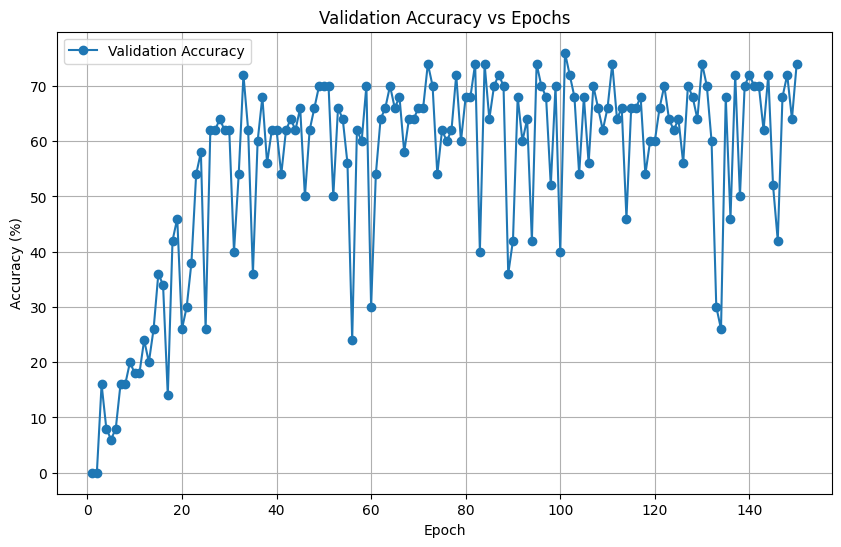

In [84]:
best2 = study2.best_params
net = myNN2(input_dim = train_dataset2.tensors[0].shape[1], hidden_layers=best2['hidden_layers'],
           hidden_units=best2['hidden_units'], dropout_rate=best2['dropout_rate'])
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(net.parameters(),lr=best2['learning_rate'])
batch_size = best2['batch_size']


train_loader_2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
validation_loader_2 = DataLoader(validation_dataset2, batch_size=batch_size, shuffle=False)
test_loader_2 = DataLoader(test_dataset2, batch_size=batch_size)

val_accuracies=[]
epochs = 150
for epoch in range(epochs):
    net.train()#  
    running_loss = 0
    for X_batch,y_batch in train_loader_2:
        optimiser.zero_grad()       
        outputs = net(X_batch)      
        loss = criterion(outputs, y_batch)  
        loss.backward()             
        optimiser.step()           
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss/len(train_loader_2.dataset)

    net.eval()
    val_loss = 0
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for X_batch, y_batch in validation_loader_2:
            preds = net(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds)
            all_trues.append(y_batch)
    all_preds = torch.cat(all_preds).flatten()
    all_trues = torch.cat(all_trues).flatten()
    rmse = torch.sqrt(torch.mean((all_preds-all_trues)**2))
    tol = 5.0 #tolerance percentage +- 5%
    in_tol = torch.abs(all_preds-all_trues)<=tol
    accuracy = 100*torch.sum(in_tol)/len(all_trues)
    val_accuracies.append(accuracy.item())
    val_loss /= len(validation_loader_2.dataset)

    if (epoch+1) % 20 ==0:
        print(f"Epoch {epoch+1}/{epochs} - Test Accuracy (±{tol}%): {accuracy:.2f}%")
print(f"Epoch {epoch+1}/{epochs} - Test Accuracy (±{tol}%): {accuracy:.2f}%")

plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy vs Epochs')
plt.grid(True)
plt.legend()
plt.show()

In [85]:
net.eval()
all_test_preds = []
all_test_trues = []
with torch.no_grad():
    for X_batch, y_batch in test_loader_2:
        preds = net(X_batch)
        all_test_preds.append(preds)
        all_test_trues.append(y_batch)

all_test_preds = torch.cat(all_test_preds).flatten()
all_test_trues = torch.cat(all_test_trues).flatten()

y_pred = all_test_preds.numpy()
y_true = all_test_trues.numpy()

rmse_2 = mean_squared_error(y_true, y_pred)

r2_2 = r2_score(y_true, y_pred)

print(f"Test RMSE: {rmse_2:.4f}")
print(f"Test R^2 score: {r2_2:.4f}")

Test RMSE: 21.0138
Test R^2 score: 0.8022


##  Brief Observations and conclusion 2

Here my R^2 score is even better around 0.79 with 1 being a perfect score, this is a significant improvement over the generic unaltered data clearly showing how much better an augmented dataset can be for a regressor style neural network. This was similar for Q1 with my gradient boost regressor that also performed much better with a limitedly altered dataset that was all scaled as to not intorduce skewness. 
The mean squared error here is also significantly better an almost 34% decrease in error means that the augmented logarithm data shows more clear linear relations that ar otherwise harder for the neural network to see with such a limited dataset size. An alternative to this would have been using a larger dataset with over 1000 points.

#   Attempt 3- Augmenting the Data with noise and false relations

Here I will introduce 9 new engineered features from the original dataset but they will be a mix of useful and unconnected relations to **Mission Success** in order to add noise to the data and NN model. I am expecting to get a much worse RMSE score and possibly a negative R2 score as in Q2, highlighting that whilst feature engineering is an important part of model training, if not done right with features that make sence, it can be a detriment through introducing skewness and false relations/coincidence.
Finally I will repeat this experiment with the same engineered features but scaled as well to attempt to get a decent R2 score.  

In [73]:
encoded_1.head()

,Launch Date,Distance from Earth (light-years),Mission Duration (years),Mission Cost (billion USD),Scientific Yield (points),Crew Size,Fuel Consumption (tons),Payload Weight (tons),Target Type_Asteroid,Target Type_Exoplanet,...,Target Name_Proxima b,Target Name_Titan,Mission Type_Colonization,Mission Type_Exploration,Mission Type_Mining,Mission Type_Research,Launch Vehicle_Ariane 6,Launch Vehicle_Falcon Heavy,Launch Vehicle_SLS,Launch Vehicle_Starship
0,9132,7.05,5.2,526.68,64.3,21,731.88,99.78,0,0,...,0,1,1,0,0,0,0,0,1,0
1,9139,41.76,23.0,234.08,84.4,72,4197.41,45.72,0,1,...,0,0,1,0,0,0,0,0,0,1
2,9146,49.22,28.8,218.68,98.6,16,4908.00,36.12,1,0,...,0,0,0,1,0,0,0,0,0,1
3,9153,26.33,17.8,232.89,36.0,59,2569.05,40.67,0,1,...,0,1,1,0,0,0,0,0,0,1
4,9160,8.67,9.2,72.14,96.5,31,892.76,12.40,0,1,...,1,0,0,0,1,0,0,0,0,1


In [91]:
data_3 = encoded_1.copy()
data_3['Total person years'] = data_3['Crew Size'] * data_3['Mission Duration (years)']
data_3['cost per person year'] = data_3['Mission Cost (billion USD)'] / data_3['Total person years']
data_3['scientific efficiency'] = data_3['Scientific Yield (points)'] / data_3['Mission Cost (billion USD)']
data_3['scientific yield per year'] = data_3['Scientific Yield (points)'] / data_3['Mission Duration (years)']
data_3['MpG'] = data_3['Payload Weight (tons)'] / data_3['Fuel Consumption (tons)']
data_3['human efficiency'] = data_3['Scientific Yield (points)'] / (data_3['Crew Size'] * data_3['Mission Duration (years)'])
data_3['cost per LY'] = data_3['Mission Cost (billion USD)'] / data_3['Distance from Earth (light-years)']
data_3['energy efficiency'] = data_3['Fuel Consumption (tons)'] / (data_3['Payload Weight (tons)'] * data_3['Distance from Earth (light-years)'])
data_3['technology improvement'] = data_3['Launch Date'] * data_3['Scientific Yield (points)'] / data['Mission Success (%)']


In [92]:
X = data_3.values.astype(np.float32)#   converting to a long type float from integers
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)
print(X_tensor.shape)
print(y_tensor.shape)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42)#    90% split after train and validation split 
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size = 0.5, random_state=42)

train_dataset3 = TensorDataset(X_train,y_train)
validation_dataset3 = TensorDataset(X_val,y_val)
test_dataset3 = TensorDataset(X_val,y_val)

torch.Size([500, 37])
torch.Size([500, 1])


In [93]:
class myNN3(nn.Module):
    def __init__(self, input_dim, hidden_layers, hidden_units, dropout_rate):
        super().__init__()
        layers = []
        in_dim = input_dim

        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_dim, hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_units

        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def objective(trial):
    hidden_layers = trial.suggest_int('hidden_layers', 2, 7)
    hidden_units = trial.suggest_int('hidden_units', 16, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    train_loader = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset3, batch_size=batch_size, shuffle=False)

    net = myNN3(input_dim=X_train.shape[1], hidden_layers=hidden_layers, hidden_units=hidden_units, dropout_rate=dropout_rate)
    criterion = nn.MSELoss()
    optimiser = optim.Adam(net.parameters(),lr=learning_rate)

    epochs = 50
    for epoch in range(epochs):
        net.train()#    training mode
        running_loss = 0
        for X_batch,y_batch in train_loader:
            optimiser.zero_grad()       # zero the gradient buffers
            outputs = net(X_batch)       # forward pass
            loss = criterion(outputs, y_batch)  # compute loss
            loss.backward()             # backward pass
            optimiser.step()            # update weights
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss/len(train_loader.dataset)
    


    val_loss = 0
    net.eval()# validation mode
    all_preds =[]
    all_trues =[]
    with torch.no_grad():
        for X_batch, y_batch in validation_loader:
            preds = net(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds)
            all_trues.append(y_batch)
    all_preds = torch.cat(all_preds).flatten()
    all_trues = torch.cat(all_trues).flatten()
    val_loss = criterion(all_preds, all_trues).item()
    return val_loss

optuna.logging.set_verbosity(optuna.logging.WARNING)
study3 = optuna.create_study(direction="minimize")
study3.optimize(objective, n_trials=50)

print("Best trial:")
trial3 = study3.best_trial
print(trial3.params)

Best trial:
{'hidden_layers': 2, 'hidden_units': 116, 'dropout_rate': 0.10115788982544917, 'learning_rate': 0.009986605741231374, 'batch_size': 64}


Epoch 20/50 - Test Accuracy (±5.0%): 30.00%
Epoch 40/50 - Test Accuracy (±5.0%): 34.00%
Epoch 50/50 - Test Accuracy (±5.0%): 38.00%


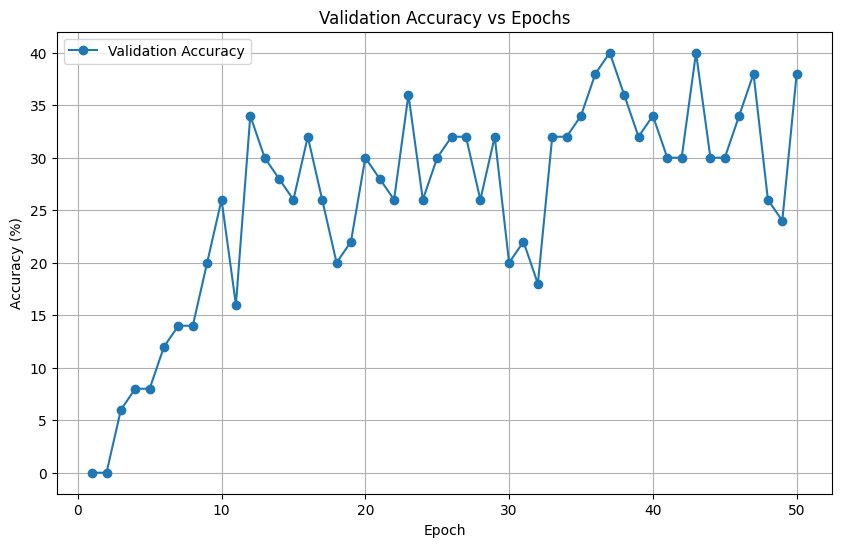

In [96]:
best3 = study3.best_params
net = myNN3(input_dim = train_dataset3.tensors[0].shape[1], hidden_layers=best3['hidden_layers'],
           hidden_units=best3['hidden_units'], dropout_rate=best3['dropout_rate'])
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(net.parameters(),lr=best3['learning_rate'])
batch_size = best3['batch_size']


train_loader_3 = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)
validation_loader_3 = DataLoader(validation_dataset3, batch_size=batch_size, shuffle=False)
test_loader_3 = DataLoader(test_dataset3, batch_size=batch_size)

val_accuracies=[]
epochs = 50
for epoch in range(epochs):
    net.train()#  
    running_loss = 0
    for X_batch,y_batch in train_loader_3:
        optimiser.zero_grad()       
        outputs = net(X_batch)      
        loss = criterion(outputs, y_batch)  
        loss.backward()             
        optimiser.step()           
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss/len(train_loader_3.dataset)

    net.eval()
    val_loss = 0
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for X_batch, y_batch in validation_loader_3:
            preds = net(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds)
            all_trues.append(y_batch)
    all_preds = torch.cat(all_preds).flatten()
    all_trues = torch.cat(all_trues).flatten()
    rmse = torch.sqrt(torch.mean((all_preds-all_trues)**2))
    tol = 5.0 #tolerance percentage +- 5%
    in_tol = torch.abs(all_preds-all_trues)<=tol
    accuracy = 100*torch.sum(in_tol)/len(all_trues)
    val_accuracies.append(accuracy.item())
    val_loss /= len(validation_loader_3.dataset)

    if (epoch+1) % 20 ==0:
        print(f"Epoch {epoch+1}/{epochs} - Test Accuracy (±{tol}%): {accuracy:.2f}%")
print(f"Epoch {epoch+1}/{epochs} - Test Accuracy (±{tol}%): {accuracy:.2f}%")

plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy vs Epochs')
plt.grid(True)
plt.legend()
plt.show()

In [97]:
net.eval()
all_test_preds = []
all_test_trues = []
with torch.no_grad():
    for X_batch, y_batch in test_loader_3:
        preds = net(X_batch)
        all_test_preds.append(preds)
        all_test_trues.append(y_batch)

all_test_preds = torch.cat(all_test_preds).flatten()
all_test_trues = torch.cat(all_test_trues).flatten()

y_pred = all_test_preds.numpy()
y_true = all_test_trues.numpy()

rmse_3 = mean_squared_error(y_true, y_pred)

r2_3 = r2_score(y_true, y_pred)

print(f"Test RMSE: {rmse_3:.4f}")
print(f"Test R^2 score: {r2_3:.4f}")

Test RMSE: 146.9526
Test R^2 score: -0.3835


##  Brief Observations and conclusion 3

For this final test as can be seen above, the root mean square score is larger than the actual data range of percentages, and therefore shows that the amount of noise and randomness I have introduced into the data has confused the model to the point that it is not learning anything, leading to the R2 score becoming negative. A negative value means that not only is there no correlation between model's guesses and the actual data test values, but it is worse than just guessing the mean of the data every time (my model has a more than 50% error bar on each guess). 

If I wanted to improve this and get a somewhat related output I would scale my data using log and standard scaler such as with part a and b as here I wanted to highlight how poor a confused neural network performs. 

#   Conclusion

In conclusion the three datasets yielded vastly different scores from the same models.
**1. Unaltered data:** The baseline model trained on the original dataset achieved a test RMSE of 12.12 and an R2 of 0.42. This indicates that the neural network was able to capture some of the underlying relationships between input features and the target, but there was still substantial variance unexplained in the RMSE. The moderate R2 reflects the model’s ability to generalize to unseen data while being limited by the amount and linearity between the original features.

**2. Augmented data with meaningful relations:** When the dataset was augmented with additional features that were carefully engineered to reflect meaningful relationships, the model’s R2 improved significantly to 0.80, despite an increase in RMSE to 21.01. The higher R2 suggests that the network could explain a much larger portion of the variance in the target, indicating that these additional features helped the model better capture the structure of the underlying data. The increase in RMSE is likely due to differences in the scale or distribution of the new features, which can increase absolute error even as predictive quality (R2) improves. Overall, this shows that well-designed augmentation can enhance model understanding and predictive capability, provided the features are relevant to the target.

**3. Augmented data with noise and random relations:** In contrast, augmenting the dataset with irrelevant or random features resulted in catastrophic performance degradation, with RMSE rising to 146.95 and R2 dropping to −0.38. The negative R2 indicates that the network is performing worse than simply predicting the mean of the target for all examples. This occurs because the noisy features introduce unimportant correlations and conflicting signals, which confuse the network during training and lead to overfitting on meaningless patterns. The model is unable to identify the true relationships within the data, illustrating that adding random or uninformative features can severely hinder generalization.

Taken together, these three approaches highlight that the quality and relevance of input features are far more important than sheer quantity. While carefully crafted augmentation can provide richer information and improve model performance, indiscriminate addition of noisy or irrelevant features can drastically impair learning. This experiment underscores the importance of thoughtful feature engineering and selective augmentation when using neural networks

In [98]:
print("Unaltered data")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2 score: {r2:.4f}")
print("Augmented data with meaningful relations")
print(f"Test RMSE: {rmse_2:.4f}")
print(f"Test R^2 score: {r2_2:.4f}")
print("Augmented data with noise and random relations")
print(f"Test RMSE: {rmse_3:.4f}")
print(f"Test R^2 score: {r2_3:.4f}")

Unaltered data
Test RMSE: 12.1224
Test R^2 score: 0.4245
Augmented data with meaningful relations
Test RMSE: 21.0138
Test R^2 score: 0.8022
Augmented data with noise and random relations
Test RMSE: 146.9526
Test R^2 score: -0.3835
